In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

import seaborn as sns
import math
import numpy as np

pd.options.display.max_columns = None

In [15]:
df = pd.read_csv("../../Files/pitch_class_trackman_games.csv").iloc[:, 1:].copy()
df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter,predTaggedGroup,predTaggedPitch
0,16,2025-02-21,14:11:11.82,1,1,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,91.57195,-2.628586,-3.174826,2207.441249,223.493945,1:30,5.92754,1.62175,6.23650,-16.31336,16.70143,14.82485,2.13779,-0.07463,83.63026,-5.743706,-0.500993,0.413548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.52898,9.70662,-1.39160,50.0,5.72280,6.74045,-132.78428,-6.55979,-15.21685,28.61852,-14.85611,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,ff2f8a70-f08f-11ef-b516-25f8a7d41699,91.14411,NaN,NaN,7.94169,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:11.82,2025-02-21T14:11:11.8251008-06:00,2025-02-21T20:11:11.8251008Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,dc191950-da93-4970-8769-e446650cd580,54.26343,-133.70000,14.30926,5.92509,-6.08443,-7.42805,-1.61507,7.22735,-7.60842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.000,0.000,0.999,0.001,0.000,0.000,Fastball,Four-Seam
1,18,2025-02-21,14:11:44.93,1,3,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,1,1,Changeup,Changeup,BallCalled,Undefined,Undefined,Undefined,0,0,83.85827,-0.843377,-1.406615,1784.528129,265.139924,2:45,5.50880,1.81538,6.11002,-36.65037,2.86567,18.69273,1.67444,2.07215,76.78886,-7.631068,1.

In [16]:
pitch_colors = {'Four-Seam': 'blueviolet',
                'Sinker': 'magenta', 
                'Cutter': 'crimson', 
                'Changeup': 'cyan', 
                'Splitter': 'teal', 
                'Slider': 'lawngreen', 
                'Curveball': 'yellow',
                # 'Sweeper': 'orange',
                # 'Knuckleball': '#1BB999',
                # 'Unknown': 'lightgrey'
                } 

valid_pitches = {k for k in pitch_colors if k != 'Unknown'}
df['PlateLocSide'] = df['PlateLocSide']*-1

In [17]:
strike_zone_width = 1.66 # 0.83 + 0.83
strike_zone_height = 2.34 # 3.72 - 1.38
left_of_zone = -strike_zone_width / 2
right_of_zone = strike_zone_width / 2
bottom_of_zone = 1.38
top_of_zone = 3.72
ball_width = (9/np.pi)/12

font_properties = {'family': 'DejaVu Sans', 'size': 12}
font_properties_titles = {'family': 'DejaVu Sans', 'size': 12}
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

sns.set_theme(style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.5, color_codes=True, rc=None)
mpl.rcParams['figure.dpi'] = 300

In [24]:
def plot_pitcher_pitch_heatmap(df: pd.DataFrame, pitcher_name: str, pitch_name: str, ax: plt.axes):
    """
    Plots KDE heatmaps of pitch locations for all pitch types of a single pitcher,
    with a true MLB strike zone and handling missing pitch data.
    """
    df = df[df['Pitcher'] == pitcher_name].reset_index(drop=True).copy()
    sns.kdeplot(data=df[(df['predTaggedPitch'] == pitch_name) 
                        # & (df['Strikes'] == 2)
                        ], x='PlateLocSide', y='PlateLocHeight', cmap='coolwarm', fill=True)
    pitch_count = df[(df['predTaggedPitch'] == pitch_name) 
                    #  & (df['Strikes'] == 2)
                     ].shape[0]
    pitch_usage = round((pitch_count / (df
                                        # [df['Strikes'] == 2]
                                        ).shape[0]) * 100, 1)

    ## strike zone code
    outer_zone_width = strike_zone_width + 0.48
    outer_zone_height = strike_zone_height + 0.48
    bottom_of_outer_zone = bottom_of_zone - 0.24
    left_of_outer_zone = left_of_zone - 0.24

    strike_zone = patches.Rectangle((left_of_zone, bottom_of_zone), strike_zone_width, strike_zone_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(strike_zone)
    
    outer_zone = patches.Rectangle((left_of_outer_zone, bottom_of_outer_zone), outer_zone_width, outer_zone_height, linewidth=1, edgecolor='black', alpha=0.8, facecolor='none')
    ax.add_patch(outer_zone)

    for i in range(1, 3):  
        x = left_of_zone + (i * strike_zone_width / 3)
        ax.plot([x, x], [bottom_of_zone, bottom_of_zone + strike_zone_height], color='gray', linestyle='-')
    for i in range(1, 3):  
        y = bottom_of_zone + (i * strike_zone_height / 3)
        ax.plot([left_of_zone, left_of_zone + strike_zone_width], [y, y], color='gray', linestyle='-')

    ax.grid()
    ax.legend().remove()
    ax.set_xticks(range(-2, 3, 1))
    ax.set_xticklabels(range(-2, 3, 1), fontdict=font_properties)
    ax.set_yticks(range(0, 6, 1))
    ax.set_yticklabels(range(0, 6, 1), fontdict=font_properties)
    x_min, x_max = df['PlateLocSide'].min(), df['PlateLocSide'].max()
    y_min, y_max = df['PlateLocHeight'].min(), df['PlateLocHeight'].max()
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_axis_off()
    ax.set_xlabel('Horiontal Location (ft.)', fontdict=font_properties_axes)
    ax.set_ylabel('Vertical Location (ft.)', fontdict=font_properties_axes)
    pitch_name_cleaned = " ".join(pitcher_name.split(', ')[::-1])
    ax.set_title(f"{pitch_name_cleaned}'s {pitch_name}\n", fontdict=font_properties_titles, loc='left', pad=6)
    ax.text(0.0, 1.02, f"{pitch_count} Pitches ({pitch_usage}%)", transform=ax.transAxes, ha='left', va='bottom', fontsize=10, color='gray')
    ax.set_aspect('equal', adjustable='box')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


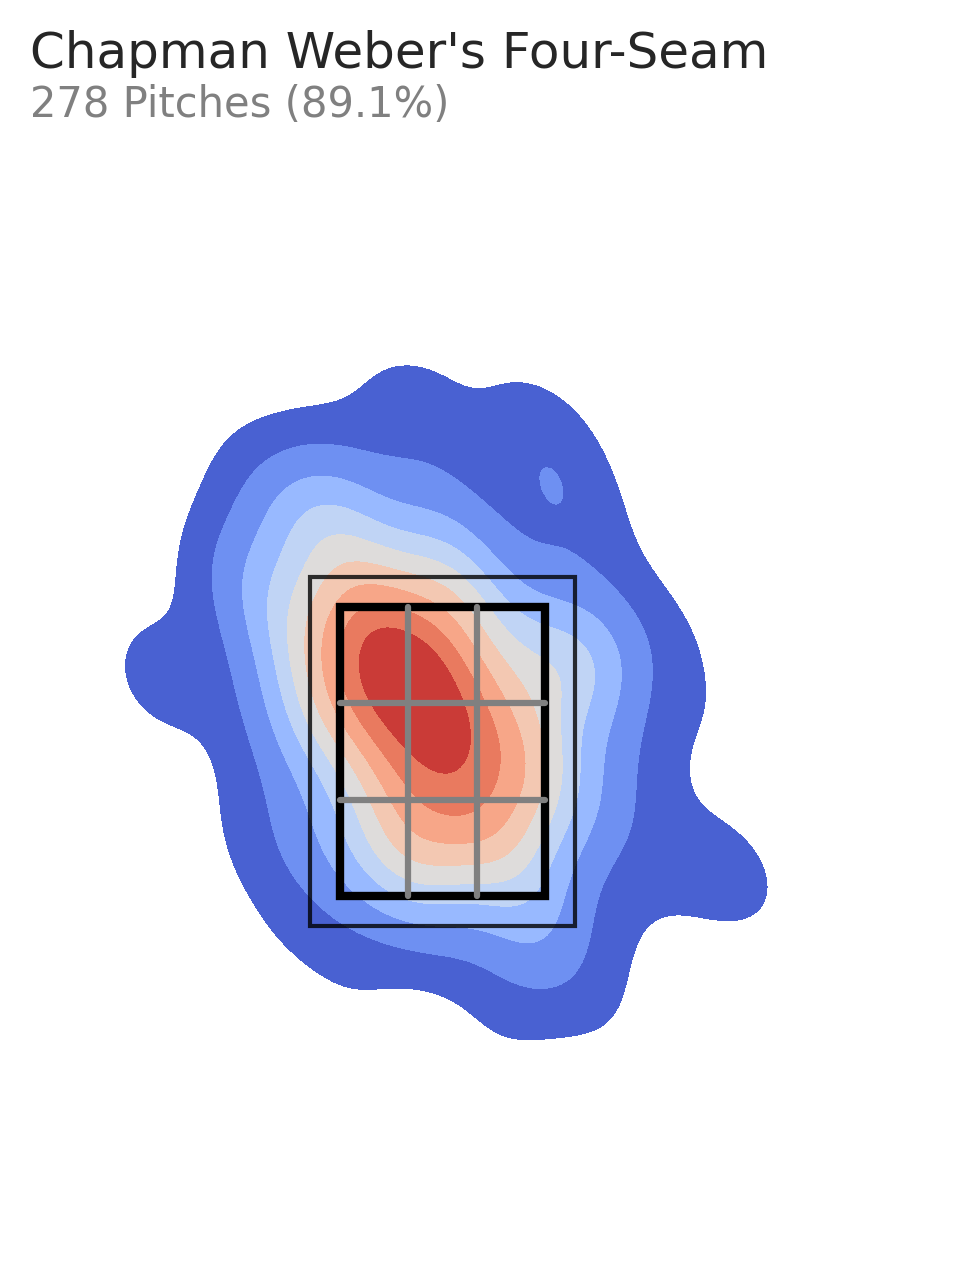

In [28]:
plot_pitcher_pitch_heatmap(df, 'Weber, Chapman', 'Four-Seam', plt.subplots()[1])

In [29]:
df[df["Pitcher"] == "Weber, Chapman"]['predTaggedPitch'].value_counts(normalize=True)

predTaggedPitch
Four-Seam    0.891026
Slider       0.086538
Curveball    0.019231
Cutter       0.003205
Name: proportion, dtype: float64

In [21]:
df[df["Pitcher"] == "Weber, Chapman"].groupby('predTaggedPitch').agg({'RelSpeed': 'max', 'InducedVertBreak': 'max'})

,RelSpeed,InducedVertBreak
predTaggedPitch,,
Curveball,78.87590,-2.31508
Cutter,85.21744,7.38244
Four-Seam,92.08434,30.42706
Slider,81.78370,3.79091


In [13]:
pitcher_name = "Weber, Chapman"
pitcher_data = df[df["Pitcher"] == pitcher_name]

# Then you can run your for loop
for i, pitch in enumerate(pitcher_data['TaggedPitchType'].unique().tolist()):
    print(pitch)

Four-Seam
Slider
Cutter
Changeup
